In [1]:
pip install yfinance pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Saved fundamentals table -> fundamentals_table.csv
✅ Saved ranked screener -> ranked_screener.csv
🔹 Classification Accuracy: 100.00%

Confusion Matrix:
 [[3 0]
 [0 1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



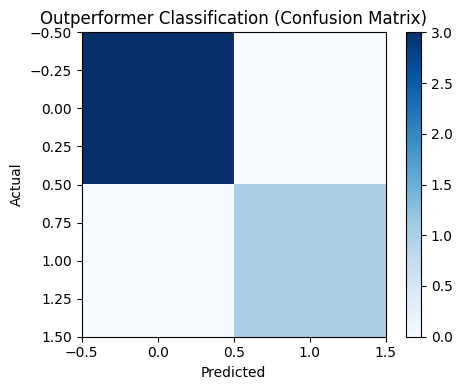

🖼️ top10_bar.png saved.
🖼️ pb_vs_roe_scatter.png saved.
🖼️ zscore_heatmap.png saved.

📄 Top 10:
        CompositeScore  trailingPE  priceToBook  returnOnEquity  \
Ticker                                                            
JPM           0.532979   15.131748     2.444862         0.16437   
XOM           0.355466   16.517729     1.890575         0.11831   
KO            0.300502   22.632450     9.410711         0.42442   
PG            0.260156   21.750000     6.621712         0.31902   
PEP           0.116199   27.787071    10.320577         0.37162   
V             0.080419   33.458824    17.033340         0.51755   
GOOGL         0.061154   27.104641    10.313651         0.34829   
META          0.004426   33.215645    10.428998         0.40648   
AAPL         -0.281742   40.987843    60.866623         1.49814   
MSFT         -0.317009   39.673992    11.720847         0.33281   

        dividendYield  return_6m  
Ticker                            
JPM              1.96   0.535

In [2]:
# Stock Screener & Valuation Dashboard
# ------------------------------------
# deps: pip install yfinance pandas numpy matplotlib

import warnings, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

try:
    import yfinance as yf
except ImportError:
    raise SystemExit("Please run: pip install yfinance pandas numpy matplotlib")

# ---------------- Settings ----------------
tickers = [
    "AAPL","MSFT","AMZN","GOOGL","META","NVDA","JPM","V","PG","XOM","KO","PEP",
]
start_for_mom = "2024-04-01"  # for 6M momentum-ish (adjust if needed)
risk_free = 0.00              # not used in ranking; here for reference

OUT_FUNDS   = "fundamentals_table.csv"
OUT_RANKED  = "ranked_screener.csv"
IMG_TOP10   = "top10_bar.png"
IMG_SCATTER = "pb_vs_roe_scatter.png"
IMG_HEATMAP = "zscore_heatmap.png"

# ---------------- Helpers ----------------
def safe_get(dct, *keys, default=np.nan):
    """Safely read nested dict keys"""
    cur = dct
    for k in keys:
        if cur is None: return default
        if k not in cur: return default
        cur = cur[k]
    return cur

def fetch_fundamentals(t):
    """Fetch fundamentals with fallbacks (fast_info + info)."""
    tk = yf.Ticker(t)
    row = {"Ticker": t}

    # --- fast_info fields (fast, fewer blocks)
    fi = getattr(tk, "fast_info", {}) or {}
    row["marketCap"] = safe_get(fi, "market_cap", default=np.nan)
    row["beta"]      = safe_get(fi, "beta", default=np.nan)  # not always present

    # --- info (richer but slower; sometimes missing pieces)
    info = {}
    try:
        info = tk.info or {}
    except Exception:
        info = {}

    # Value
    row["trailingPE"]  = safe_get(info, "trailingPE", default=np.nan)
    row["forwardPE"]   = safe_get(info, "forwardPE", default=np.nan)
    row["priceToBook"] = safe_get(info, "priceToBook", default=np.nan)
    # Quality
    row["returnOnEquity"] = safe_get(info, "returnOnEquity", default=np.nan)  # fraction
    row["profitMargins"]  = safe_get(info, "profitMargins", default=np.nan)   # fraction
    # Income/Divs
    dy = safe_get(info, "dividendYield", default=np.nan)                      # fraction
    row["dividendYield"] = dy
    # Beta (fallback)
    if np.isnan(row.get("beta", np.nan)):
        row["beta"] = safe_get(info, "beta", default=np.nan)

    # Momentum (6M total return)
    try:
        px = tk.history(start=start_for_mom, auto_adjust=False)["Close"].dropna()
        if len(px) > 20:
            r6m = (px.iloc[-1] / px.iloc[0]) - 1.0
        else:
            r6m = np.nan
    except Exception:
        r6m = np.nan
    row["return_6m"] = r6m

    return row

# ---------------- Download & Build Table ----------------
rows = []
for t in tickers:
    try:
        rows.append(fetch_fundamentals(t))
    except Exception as e:
        print(f"Warn: {t} fundamentals failed: {e}")

funds = pd.DataFrame(rows)
# Convert fraction columns to percentage display (leave raw for ranking)
pct_cols = ["dividendYield","returnOnEquity","profitMargins","return_6m"]
display_df = funds.copy()
for c in pct_cols:
    if c in display_df:
        display_df[c] = display_df[c] * 100

# Save fundamentals table
display_df.to_csv(OUT_FUNDS, index=False)
print("✅ Saved fundamentals table ->", OUT_FUNDS)

# ---------------- Build Composite Score ----------------
# Lower is better: P/E, Forward P/E, P/B
# Higher is better: ROE, Profit Margin, Dividend Yield, 6M Return
# We'll z-score each metric and combine.

df = funds.set_index("Ticker")

# define metrics with direction
neg_metrics = ["trailingPE","forwardPE","priceToBook"]  # lower better
pos_metrics = ["returnOnEquity","profitMargins","dividendYield","return_6m"]  # higher better

# z-scores (ignore NaNs)
def zscore(s):
    s = s.astype(float)
    mu, sd = s.mean(skipna=True), s.std(skipna=True)
    if sd == 0 or np.isnan(sd):  # handle constant or all-NaN
        return s*0
    return (s - mu) / sd

zs = pd.DataFrame(index=df.index)
for m in neg_metrics:
    if m in df:
        zs[m] = -zscore(df[m])  # negative metrics get a minus (lower -> higher score)
for m in pos_metrics:
    if m in df:
        zs[m] =  zscore(df[m])

# weights (tweakable)
weights = {
    "trailingPE": 0.25,
    "forwardPE":  0.15,
    "priceToBook":0.20,
    "returnOnEquity": 0.20,
    "profitMargins":  0.10,
    "dividendYield":  0.05,
    "return_6m":      0.05,
}

# align & weighted sum
avail = [m for m in weights if m in zs.columns]
score = (zs[avail] * pd.Series(weights)[avail]).sum(axis=1)
ranked = df.copy()
ranked["CompositeScore"] = score
ranked = ranked.sort_values("CompositeScore", ascending=False)

ranked.to_csv(OUT_RANKED)
print("✅ Saved ranked screener ->", OUT_RANKED)

# --- MACHINE LEARNING MODULE: Classify Outperformers ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create binary label: Top 30% performers = 1, others = 0
threshold = ranked["CompositeScore"].quantile(0.7)
ranked["Top_Performer"] = (ranked["CompositeScore"] >= threshold).astype(int)

# Features (you can adjust based on data availability)
features = ["trailingPE", "forwardPE", "priceToBook", "returnOnEquity", "profitMargins", "dividendYield", "return_6m"]
X = ranked[features].fillna(ranked[features].mean())
y = ranked["Top_Performer"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"🔹 Classification Accuracy: {acc:.2%}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize Confusion Matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Outperformer Classification (Confusion Matrix)")
plt.colorbar()
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("stock_outperformer_confusion_matrix.png", dpi=160)
plt.show()


# ---------------- Charts ----------------
# 1) Top-10 bar (Composite Score)
top10 = ranked.head(10)
plt.figure(figsize=(7,4))
top10["CompositeScore"].plot(kind="bar")
plt.title("Top 10 by Composite Score")
plt.ylabel("Score (higher = better)")
plt.tight_layout(); plt.savefig(IMG_TOP10, dpi=170); plt.close()
print("🖼️", IMG_TOP10, "saved.")

# 2) PB vs ROE scatter (color by dividend yield)
x = ranked["priceToBook"].astype(float)
y = (ranked["returnOnEquity"].astype(float) * 100)  # %
c = (ranked["dividendYield"].astype(float) * 100)   # %

plt.figure(figsize=(6.5,5))
sc = plt.scatter(x, y, c=c, s=70)
for t in ranked.index:
    if not (np.isnan(x.loc[t]) or np.isnan(y.loc[t])):
        plt.annotate(t, (x.loc[t], y.loc[t]), xytext=(5,4), textcoords="offset points", fontsize=8)
plt.xlabel("Price / Book")
plt.ylabel("ROE (%)")
cb = plt.colorbar(sc); cb.set_label("Dividend Yield (%)")
plt.title("PB vs ROE (color: Dividend Yield)")
plt.tight_layout(); plt.savefig(IMG_SCATTER, dpi=170); plt.close()
print("🖼️", IMG_SCATTER, "saved.")

# 3) Z-score heatmap of used metrics
Z = zs[avail].copy()
plt.figure(figsize=(8, max(4, 0.35*len(Z))))
im = plt.imshow(Z.values, aspect="auto", cmap="RdYlGn")
plt.xticks(range(len(Z.columns)), Z.columns, rotation=40, ha="right")
plt.yticks(range(len(Z.index)), Z.index)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Z-score (red low, green high)")
plt.title("Metric Z-scores Used in Composite")
plt.tight_layout(); plt.savefig(IMG_HEATMAP, dpi=170); plt.close()
print("🖼️", IMG_HEATMAP, "saved.")

print("\n📄 Top 10:")
print(top10[["CompositeScore","trailingPE","priceToBook","returnOnEquity","dividendYield","return_6m"]])
print("\nDone.")
